<a href="https://colab.research.google.com/github/TAUforPython/ts-forecasting-ensemble/blob/master/example%20TDA%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install ripser persim --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.3/827.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 5.9 MB/s eta 0:00:00


Ripser and Persim imported successfully.
Generated 40 signals (20 baseline, 20 stress).


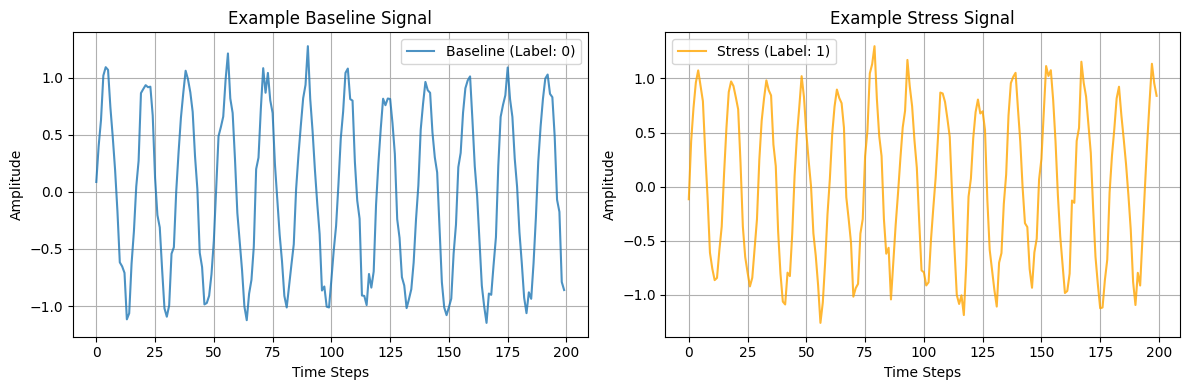

Signal 1 (Label: 0): Mean TP H0: inf, Mean TP H1: 0.7867, Std TP H0: nan, Std TP H1: 0.1482
Signal 2 (Label: 1): Mean TP H0: inf, Mean TP H1: 1.2775, Std TP H0: nan, Std TP H1: 0.0980

Calculated feature vectors for all signals. Shape: (40, 16)


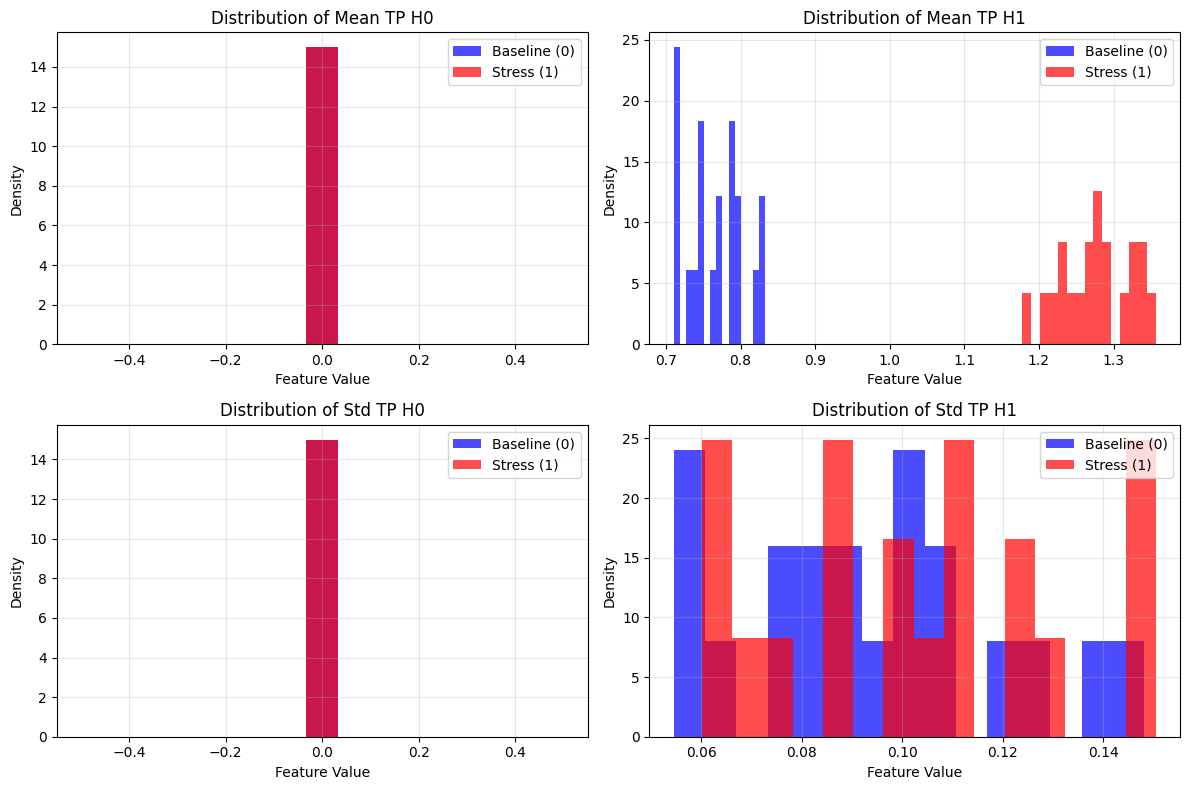


--- Classification Example ---
Classification Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    Baseline       1.00      1.00      1.00         6
      Stress       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



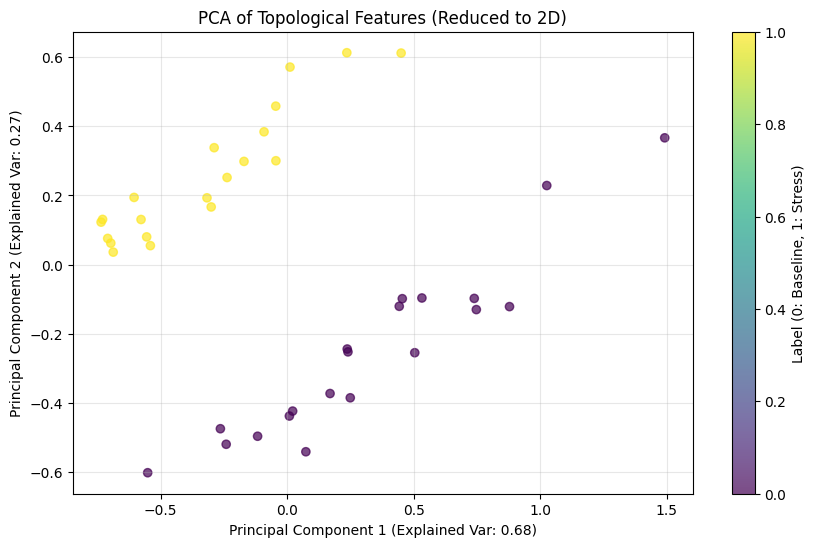


--- Analysis Complete ---
This enhanced code demonstrated:
1. Generating two distinct types of time series (Baseline vs Stress)
2. Visualizing example signals from each type
3. Calculating topological features (Total Persistence, Max Lifetime, Number of Features, Persistent Entropy) for subwindows
4. Aggregating subwindow features (mean, std) to create a feature vector for each signal window
5. Visualizing the distribution of these features for the two signal types
6. Training a simple classifier (Random Forest) on the topological features to distinguish signal types
7. Evaluating the classifier's performance
8. Visualizing the high-dimensional feature space projected to 2D using PCA, showing potential separation between classes
This process mimics the core methodology described in the paper for using TDA features in classification tasks.


In [6]:

# --- Import Libraries ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # For visualizing high-dim embeddings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore") # Suppress potential warnings from TDA libraries

# Attempt to import TDA libraries
try:
    from ripser import ripser
    from persim import plot_diagrams # Optional, for prettier PD plots
    print("Ripser and Persim imported successfully.")
    RIPSER_AVAILABLE = True
except ImportError:
    print("Ripser or Persim not found. Please install them (e.g., pip install ripser persim) to run the full example.")
    RIPSER_AVAILABLE = False

# --- 1. Generate Two Distinct Types of Time Series ---
def generate_timeseries(length=1000, freq=5, noise_level=0.1, signal_type="sine", baseline_heart_rate=70, stress_heart_rate=80, stress_variability=5):
    """Generates a simple time series mimicking baseline or stress conditions."""
    t = np.linspace(0, 10, length)

    if signal_type == "baseline":
        # Simpler, more regular signal (lower HR, lower variability)
        base_freq = baseline_heart_rate / 60 # Convert bpm to Hz
        signal = np.sin(2 * np.pi * base_freq * t)
        # Add low amplitude, low frequency noise for variability
        variability_signal = 0.05 * np.sin(2 * np.pi * 0.1 * t)
        signal += variability_signal
    elif signal_type == "stress":
        # More variable signal (higher HR, higher variability)
        base_freq = stress_heart_rate / 60 # Convert bpm to Hz
        signal = np.sin(2 * np.pi * base_freq * t)
        # Add higher amplitude, more complex noise for higher variability
        variability_signal = 0.1 * np.sin(2 * np.pi * 0.3 * t) + 0.05 * np.random.normal(0, 1, size=length)
        signal += variability_signal
    else: # Default to random noise
        signal = np.random.randn(length)

    # Add general noise
    signal += np.random.normal(0, noise_level, size=length)
    return t, signal

# Parameters
baseline_params = {"baseline_heart_rate": 70, "stress_heart_rate": 70, "stress_variability": 1} # Relatively stable
stress_params = {"baseline_heart_rate": 70, "stress_heart_rate": 80, "stress_variability": 5} # Higher HR, higher variability

# Generate multiple instances of each type
num_instances = 20
window_length = 200 # Length of the window to analyze
subwindow_length = 50
subwindow_shift = 25
embedding_dim = 3
delay = 10

# Store generated signals and their labels
all_signals = []
labels = []

for i in range(num_instances):
    # Generate Baseline Signal
    t_b, sig_b = generate_timeseries(length=window_length, signal_type="baseline", **baseline_params)
    all_signals.append(sig_b)
    labels.append(0) # Label 0 for baseline

    # Generate Stress Signal
    t_s, sig_s = generate_timeseries(length=window_length, signal_type="stress", **stress_params)
    all_signals.append(sig_s)
    labels.append(1) # Label 1 for stress

all_signals = np.array(all_signals)
labels = np.array(labels)

print(f"Generated {len(all_signals)} signals ({num_instances} baseline, {num_instances} stress).")

# --- 2. Visualize Example Signals ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(all_signals[0], label=f'Baseline (Label: {labels[0]})', alpha=0.8)
plt.title('Example Baseline Signal')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(all_signals[1], label=f'Stress (Label: {labels[1]})', color='orange', alpha=0.8)
plt.title('Example Stress Signal')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 3. Define Feature Extraction Functions (with fixes for infinite values) ---
def time_delay_embedding(signal, dimension, delay):
    """Creates a time delay embedding of the signal."""
    n = len(signal)
    embedded = np.zeros((n - (dimension - 1) * delay, dimension))
    for i in range(embedded.shape[0]):
        for j in range(dimension):
            embedded[i, j] = signal[i + j * delay]
    return embedded

def extract_subwindows(signal, subwindow_length, subwindow_shift):
    """Extracts overlapping subwindows."""
    subwindows = []
    start = 0
    while start + subwindow_length <= len(signal):
        subwindow = signal[start : start + subwindow_length]
        subwindows.append(subwindow)
        start += subwindow_shift
    return subwindows

def calculate_persistence_diagrams(subwindows, embedding_dim, delay):
    """Calculates PDs for a list of subwindows."""
    all_diagrams = []
    for subwin in subwindows:
        embedded_subwin = time_delay_embedding(subwin, dimension=embedding_dim, delay=delay)
        # Calculate persistent homology (Rips complex) - only H0 and H1
        diagram = ripser(embedded_subwin, maxdim=1)['dgms']
        all_diagrams.append(diagram)
    return all_diagrams

def persistent_entropy(lifetimes):
    """Calculates persistent entropy with checks for zero sum or empty lifetimes."""
    if len(lifetimes) == 0 or np.sum(lifetimes) == 0:
        return 0.0
    p = lifetimes / np.sum(lifetimes)
    p = p[p > 0] # Remove zero probabilities
    if len(p) == 0: # If all lifetimes were zero after normalization, entropy is 0
        return 0.0
    entropy = -np.sum(p * np.log(p + 1e-8)) # Add small epsilon to avoid log(0)
    return entropy

def extract_topological_features(diagrams):
    """Extracts features from a list of persistence diagrams."""
    features = []
    for dgm in diagrams:
        # H0 features (connected components)
        h0_births = dgm[0][:, 0] if len(dgm[0]) > 0 else np.array([0])
        h0_deaths = dgm[0][:, 1] if len(dgm[0]) > 0 else np.array([0])
        h0_lifetimes = h0_deaths - h0_births

        # H1 features (1D holes/loops)
        h1_births = dgm[1][:, 0] if len(dgm[1]) > 0 else np.array([0])
        h1_deaths = dgm[1][:, 1] if len(dgm[1]) > 0 else np.array([0])
        h1_lifetimes = h1_deaths - h1_births

        # Example Features (from Section 3 of the paper)
        # 1. Total Persistence (sum of lifetimes)
        total_persistence_h0 = np.sum(h0_lifetimes)
        total_persistence_h1 = np.sum(h1_lifetimes)

        # 2. Max Lifetime
        max_lifetime_h0 = np.max(h0_lifetimes) if len(h0_lifetimes) > 0 else 0
        max_lifetime_h1 = np.max(h1_lifetimes) if len(h1_lifetimes) > 0 else 0

        # 3. Number of Features
        num_features_h0 = len(h0_lifetimes)
        num_features_h1 = len(h1_lifetimes)

        # 4. Persistent Entropy (simplified calculation, using the safe function)
        pe_h0 = persistent_entropy(h0_lifetimes)
        pe_h1 = persistent_entropy(h1_lifetimes)

        features.append([
            total_persistence_h0, total_persistence_h1,
            max_lifetime_h0, max_lifetime_h1,
            num_features_h0, num_features_h1,
            pe_h0, pe_h1
        ])
    return np.array(features) # Shape: (num_subwindows, num_feature_types)

# --- 4. Calculate Features for All Signals ---
if RIPSER_AVAILABLE:
    all_window_features = []
    for i, signal in enumerate(all_signals):
        # Extract subwindows
        subwindows = extract_subwindows(signal, subwindow_length, subwindow_shift)

        # Calculate PDs for subwindows
        diagrams = calculate_persistence_diagrams(subwindows, embedding_dim, delay)

        # Extract features from PDs of subwindows
        subwindow_features = extract_topological_features(diagrams)

        # Calculate mean and std of features across subwindows (as in the paper)
        # This creates the final feature vector for the *entire window* (signal instance)
        mean_features = np.mean(subwindow_features, axis=0)
        std_features = np.std(subwindow_features, axis=0)

        # Concatenate mean and std to form the final feature vector
        window_feature_vector = np.concatenate([mean_features, std_features])

        all_window_features.append(window_feature_vector)

        if i < 2: # Print example for first two signals
             print(f"Signal {i+1} (Label: {labels[i]}): Mean TP H0: {mean_features[0]:.4f}, Mean TP H1: {mean_features[1]:.4f}, "
                   f"Std TP H0: {std_features[0]:.4f}, Std TP H1: {std_features[1]:.4f}")

    all_window_features = np.array(all_window_features)
    print(f"\nCalculated feature vectors for all signals. Shape: {all_window_features.shape}")

    # Check for any remaining infinite or NaN values and replace them
    if np.any(np.isinf(all_window_features)) or np.any(np.isnan(all_window_features)):
        print("Warning: Infinite or NaN values found in feature matrix. Replacing with 0.")
        all_window_features = np.nan_to_num(all_window_features, nan=0.0, posinf=0.0, neginf=0.0)

    # --- 5. Visualize Feature Distribution ---
    # Plot histograms of a couple of key features (e.g., Mean Total Persistence H0 and H1)
    feature_names = [
        "Mean TP H0", "Mean TP H1", "Mean Max LT H0", "Mean Max LT H1",
        "Mean Num Feat H0", "Mean Num Feat H1", "Mean PE H0", "Mean PE H1",
        "Std TP H0", "Std TP H1", "Std Max LT H0", "Std Max LT H1",
        "Std Num Feat H0", "Std Num Feat H1", "Std PE H0", "Std PE H1"
    ]

    # Select a few representative features to plot
    feature_indices_to_plot = [0, 1, 8, 9] # Mean TP H0, Mean TP H1, Std TP H0, Std TP H1

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()

    for idx, feat_idx in enumerate(feature_indices_to_plot):
        ax = axes[idx]
        baseline_vals = all_window_features[labels == 0, feat_idx]
        stress_vals = all_window_features[labels == 1, feat_idx]

        # Only plot if there are valid values
        if len(baseline_vals) > 0 and len(stress_vals) > 0:
             ax.hist(baseline_vals, bins=15, alpha=0.7, label='Baseline (0)', color='blue', density=True)
             ax.hist(stress_vals, bins=15, alpha=0.7, label='Stress (1)', color='red', density=True)
        ax.set_title(f'Distribution of {feature_names[feat_idx]}')
        ax.set_xlabel('Feature Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- 6. Simple Classification Example ---
    print("\n--- Classification Example ---")
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(all_window_features, labels, test_size=0.3, random_state=42, stratify=labels)

    # Train a simple classifier (Random Forest)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classification Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Baseline', 'Stress']))

    # --- 7. Visualize Feature Space (using PCA) ---
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(all_window_features)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Label (0: Baseline, 1: Stress)')
    plt.title('PCA of Topological Features (Reduced to 2D)')
    plt.xlabel(f'Principal Component 1 (Explained Var: {pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'Principal Component 2 (Explained Var: {pca.explained_variance_ratio_[1]:.2f})')
    plt.grid(True, alpha=0.3)
    plt.show()

else:
    print("\n--- Topological Feature Extraction & Classification Skipped ---")
    print("Ripser library is not available. Please install it to calculate persistence diagrams and features.")

print("\n--- Analysis Complete ---")
print("This enhanced code demonstrated:")
print("1. Generating two distinct types of time series (Baseline vs Stress)")
print("2. Visualizing example signals from each type")
print("3. Calculating topological features (Total Persistence, Max Lifetime, Number of Features, Persistent Entropy) for subwindows")
print("4. Aggregating subwindow features (mean, std) to create a feature vector for each signal window")
print("5. Visualizing the distribution of these features for the two signal types")
print("6. Training a simple classifier (Random Forest) on the topological features to distinguish signal types")
print("7. Evaluating the classifier's performance")
print("8. Visualizing the high-dimensional feature space projected to 2D using PCA, showing potential separation between classes")
print("This process mimics the core methodology described in the paper for using TDA features in classification tasks.")